# Imports

In [164]:
# Import all libraries
import requests
from tqdm import trange
import zipfile
import os
from PIL import Image
import numpy as np
import pylab as plt
import matplotlib
from random import randint
from scipy.ndimage.interpolation import rotate
from skimage.transform import rescale, resize
from IPython.display import clear_output
import random
import shutil
import pandas as pd
import cv2
import time

%matplotlib inline

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate, Cropping2D, Reshape, BatchNormalization
from keras import optimizers, regularizers
from keras.optimizers import SGD, Adam
import keras.callbacks
from keras import backend as K

import h5py
from keras.utils.np_utils import to_categorical



from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D
from keras.optimizers import RMSprop, Adam
from sklearn.metrics import accuracy_score

from create_model import createResNet50, CreateKaggleModel

import stainNorm_Reinhard as stainNorm


# this part is needed if you run the notebook on Cartesius with multiple cores
n_cores = 32
config = tf.ConfigProto(intra_op_parallelism_threads=n_cores-1, inter_op_parallelism_threads=1, allow_soft_placement=True)
session = tf.Session(config=config)
K.set_session(session)
os.environ["OMP_NUM_THREADS"] = str(n_cores-1)
os.environ["KMP_BLOCKTIME"] = "1"
os.environ["KMP_SETTINGS"] = "1"
os.environ["KMP_AFFINITY"]= "granularity=fine,verbose,compact,1,0"

# Classes

In [165]:
class DataSet:
    
    def __init__(self, data_dir_x, data_dir_y = None, use_percentage = 1.0):
        self.use_percentage = use_percentage
        self.data_dir_x = data_dir_x
        self.data_dir_y = data_dir_y
    
    def get_lenght(self):
        with h5py.File(self.data_dir_x, 'r') as hdf:
            return (int)(len(hdf['x'])*self.use_percentage)
    
    def get_data(self):
        with h5py.File(self.data_dir_x, 'r') as hdf:
            return np.array( list(hdf['x']))
        
    def get_lbls(self):
        with h5py.File(self.data_dir_y, 'r') as hdf:
            data = list(hdf['y'])
            return np.reshape(data,(len(data))) 
        
    
    def show_image(self, i):
        with h5py.File(self.data_dir_x, 'r') as hdf:
            data = list(hdf['x'][i])
            img = np.array(data)
            plt.rcParams['figure.figsize'] = (3, 3)
            plt.imshow(img)
            plt.title('RGB image')
            plt.show()

        

In [166]:
class Augmentor:
    def __inint__(self):
        print("init")
        
    def rotate(self, image):
        #rotation of 10 degrees cc
        rows,cols,channels = image.shape
        deg = np.random.randint(360)
        M = cv2.getRotationMatrix2D((cols/2,rows/2),deg,1)
        image = cv2.warpAffine(image,M,(cols,rows))
        return image

In [167]:
class BatchCreator:
    
    def __init__(self, dataset, augmentor = None):
        self.dataset = dataset
        self.dataset_length = self.dataset.get_lenght()
        self.augmentor = augmentor
       
        self.index = []
        self.batch = []
        
        
    def create_batch(self, batch_size):
        start_pos = np.random.randint(0,self.dataset_length-batch_size+1)
        x_data = np.array([])
        y_data = np.array([])
      
        with h5py.File(self.dataset.data_dir_x, 'r') as hdf:
            data = np.array(list(hdf['x'][start_pos:start_pos+batch_size]))/255
            
            if(self.augmentor != None):
                #rotates ever image with an random angle of 0-360deg
                for i in range(len(data)):
                    data[i] = self.augmentor.rotate(data[i])
            
            x_data = data
        
        with h5py.File(self.dataset.data_dir_y, 'r') as hdf:
            data = list(hdf['y'][start_pos:start_pos+batch_size])
            data = np.reshape(data,(batch_size,1))
            data = to_categorical(data, num_classes=2)
            y_data = np.array(data) 
            
        return x_data, y_data
    

    def create_batch_sampling(self, batch_size):
        #init empty batch
        x_data = np.zeros( (batch_size, 96,96,3) )
        y_data = np.zeros( (batch_size, 2) )
        
        #copy the patches which have to be run again
        for i in range(len(self.index)):
            x_data[i] = self.batch[0][self.index[i]] 
            y_data[i] = self.batch[1][self.index[i]]
            
        #fill the rest of the batch with new patches
        rest = np.arange( len(self.index), batch_size)
        for i in rest:
            #get random position
            random_pos = np.random.randint(0,self.dataset_length-batch_size+1)
            #open x file
            with h5py.File(self.dataset.data_dir_x, 'r') as hdf:
                data = np.array(list(hdf['x'][random_pos]))/255
                if(self.augmentor != None):
                    #rotates ever image with an random angle of 0-360deg
                    data = self.augmentor.rotate(data)
                
                x_data[i] = data

            # open y file
            with h5py.File(self.dataset.data_dir_y, 'r') as hdf:
                data = list(hdf['y'][i])
                data = np.reshape(data,(1))
                data = to_categorical(data, num_classes=2)
                y_data[i] = data

        self.batch = [x_data, y_data]
            
        return x_data, y_data
    

        
    def get_generator(self, batch_size):
        '''returns a generator that will yield batches infinitely'''
        while True:
            yield self.create_batch(batch_size)
            
    def get_sampling_generator(self, batch_size):
        '''returns a generator that will yield batches infinitely'''
        while True:
            yield self.create_batch_sampling(batch_size)
    

In [178]:
def compute_accurancy(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

class Logger(keras.callbacks.Callback):

    def __init__(self, validation_data, saving_dir, model_name, batch_creator, sampling_threshold, sampling):
        #validation set
        self.validation_dataset = validation_data
        #traing batch generator
        self.batch_creator = batch_creator
        #threshold to for retraining a given sample
        self.sampling_threshold = sampling_threshold
        self.sampling = sampling
        self.time = time.time()
        
        #get the validation data set
        self.val_imgs = self.validation_dataset.get_data()
        self.val_lbls = self.validation_dataset.get_lbls()
        
        self.model_filename = os.path.join(saving_dir, model_name + '.h5')
        
        self.losses = []
        self.accurancies = []
        self.best_validation_acc = 0
        self.best_model = None
        self.predictions = None
    
    def on_batch_end(self, batch, logs={}):
        if self.sampling:
            
            y_pred = self.model.predict(self.batch_creator.batch[0])
            y_true = self.batch_creator.batch[1][:,1]
            y_pred_argmax = np.argmax(y_pred, axis = 1)
            y_pred_max = np.max(y_pred, axis = 1)

            index = []
            for i in range(len(y_true)):
                # if the prediction is wrong add the retrain the sample
                if y_true[i] != y_pred_argmax[i]:
                    index.append(i)
                #else if the prediction is correct but below the threshold retrain the sample
                elif y_pred_max[i] < self.sampling_threshold:
                    index.append(i)
            self.batch_creator.index = index

    
        self.losses.append(logs.get('loss'))
        
    def on_epoch_end(self, epoch, logs={}):
        
        acc = self.validate()
        self.accurancies.append([len(self.losses), acc])
        if acc > self.best_validation_acc:
            self.best_validation_acc = acc
            self.model.save(self.model_filename) # save best model to disk
            print('best model saved as {}'.format(self.model_filename))
        self.plot()   
        
        
        
        t = time.time() - self.time
        hours = int(t/3600)
        t = t - hours*3600
        minutes = int(t/60)
        t = t - minutes*60
        seconds = t
    
        #print to logger file
        with open("./logs/current_status.txt", "a") as myfile:
            myfile.write(str(epoch) + ' | ' + str(logs) + ' | val_acc = ' + str(acc) 
                         +' | time = '+str(hours)+':'+str(minutes)+':'+str(seconds)+'\n')
        
    
    def validate(self):
        predicted_lbls = np.argmax(self.model.predict(self.val_imgs), axis=1)
        return compute_accurancy(self.val_lbls, predicted_lbls)

    
    def plot(self):
        clear_output()
        N = len(self.losses)
        plt.figure(figsize=(50, 10))
        plt.subplot(1, 2, 1)
        plt.plot(range(0, N), self.losses); plt.title('losses')
        plt.subplot(1, 2, 2)
        plt.plot(*np.array(self.accurancies).T); plt.title('accurancies')
        plt.show()
   

# Load Data

In [179]:
#data dirs
data_dir = './data/'
data_dir_norm = './data/normalized/'

#train_dir_x = os.path.join(data_dir_norm, 'x_train.h5')
#train_dir_y = os.path.join(data_dir, 'camelyonpatch_level_2_split_train_y.h5')
#valid_dir_x = os.path.join(data_dir_norm, 'x_valid.h5')
#valid_dir_y = os.path.join(data_dir, 'camelyonpatch_level_2_split_valid_y.h5')
#test_dir_x = os.path.join(data_dir_norm, 'x_test.h5')

train_dir_x = os.path.join(data_dir, 'camelyonpatch_level_2_split_train_x.h5')
train_dir_y = os.path.join(data_dir, 'camelyonpatch_level_2_split_train_y.h5')
train_dir_y = os.path.join(data_dir, 'camelyonpatch_level_2_split_train_y.h5')
valid_dir_x = os.path.join(data_dir, 'camelyonpatch_level_2_split_valid_x.h5')
valid_dir_y = os.path.join(data_dir, 'camelyonpatch_level_2_split_valid_y.h5')
test_dir_x = os.path.join(data_dir, 'camelyonpatch_level_2_split_test_x.h5')

print(train_dir_x)

./data/camelyonpatch_level_2_split_train_x.h5


262144


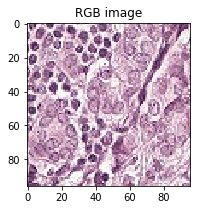

In [180]:
training_dataset = DataSet(train_dir_x, train_dir_y, use_percentage=1.0)
validation_dataset = DataSet(valid_dir_x, valid_dir_y, use_percentage=1.0)
test_dataset = DataSet(test_dir_x, use_percentage=1.0)
print(training_dataset.get_lenght())
training_dataset.show_image(1)


In [181]:
#test batch creator
augmentor = Augmentor()
batch_creator = BatchCreator(validation_dataset)
x, y = batch_creator.create_batch_sampling(5)
print(x.shape)
print(y.shape)

(5, 96, 96, 3)
(5, 2)


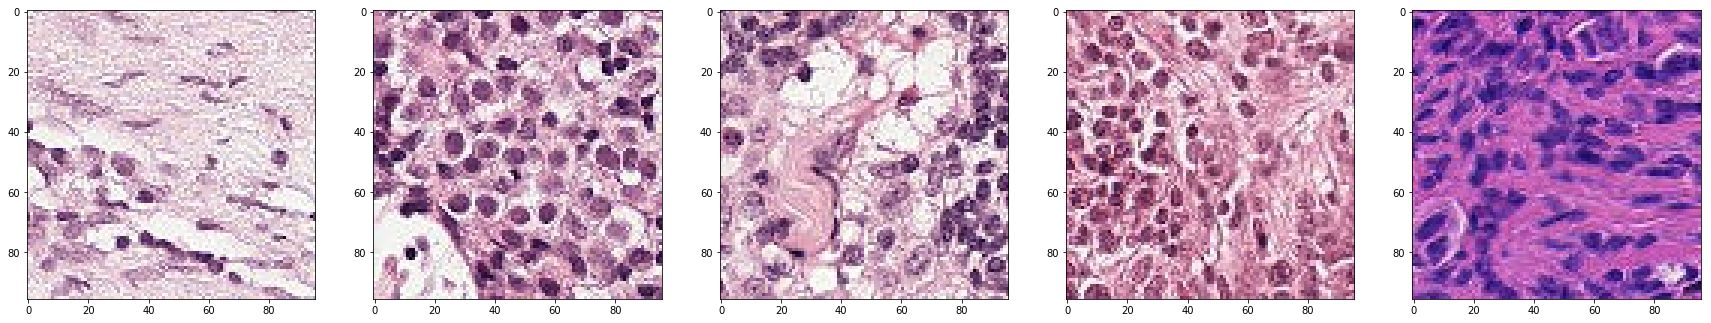

In [182]:
for i in range (5):
    plt.rcParams['figure.figsize'] = (30,30)
    plt.subplot(1,5,i+1)
    plt.imshow(x[i])

In [183]:
batch_creator.index = [0,3]
x2, y2 = batch_creator.create_batch_sampling(5)
print(x.shape)
print(y.shape)

(5, 96, 96, 3)
(5, 2)


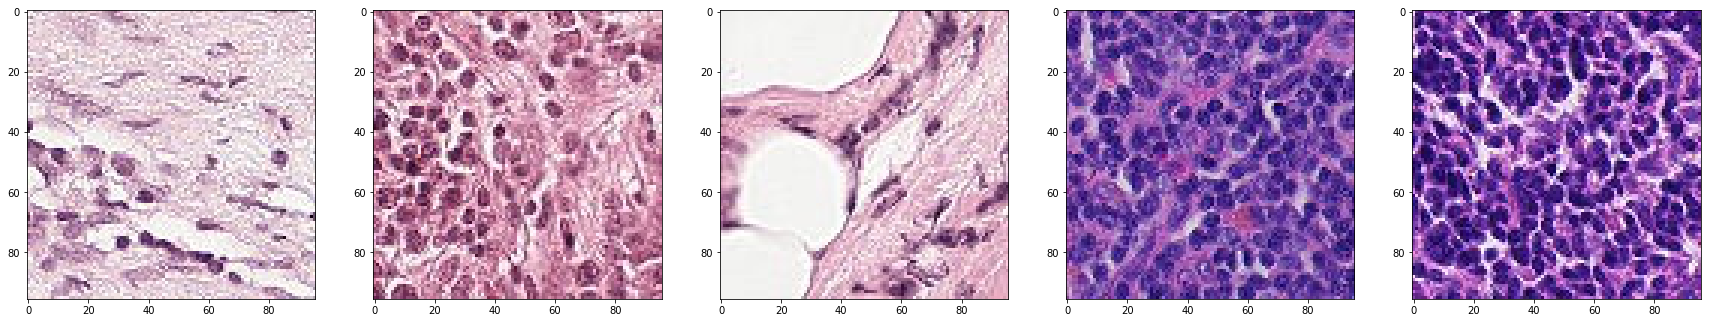

In [184]:
for i in range (5):
    plt.rcParams['figure.figsize'] = (30,30)
    plt.subplot(1,5,i+1)
    plt.imshow(x2[i])

# Create Model


In [185]:
in_t = Input(shape=(96, 96, 3))
model = createResNet50(in_t, True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 102, 102, 3)  0           input_14[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

activation_647 (Activation)     (None, 24, 24, 256)  0           add_211[0][0]                    
__________________________________________________________________________________________________
res3a_branch2a (Conv2D)         (None, 12, 12, 128)  32896       activation_647[0][0]             
__________________________________________________________________________________________________
bn3a_branch2a (BatchNormalizati (None, 12, 12, 128)  512         res3a_branch2a[0][0]             
__________________________________________________________________________________________________
activation_648 (Activation)     (None, 12, 12, 128)  0           bn3a_branch2a[0][0]              
__________________________________________________________________________________________________
res3a_branch2b (Conv2D)         (None, 12, 12, 128)  147584      activation_648[0][0]             
__________________________________________________________________________________________________
bn3a_branc

__________________________________________________________________________________________________
bn3d_branch2c (BatchNormalizati (None, 12, 12, 512)  2048        res3d_branch2c[0][0]             
__________________________________________________________________________________________________
add_215 (Add)                   (None, 12, 12, 512)  0           bn3d_branch2c[0][0]              
                                                                 activation_656[0][0]             
__________________________________________________________________________________________________
activation_659 (Activation)     (None, 12, 12, 512)  0           add_215[0][0]                    
__________________________________________________________________________________________________
res4a_branch2a (Conv2D)         (None, 6, 6, 256)    131328      activation_659[0][0]             
__________________________________________________________________________________________________
bn4a_branc

__________________________________________________________________________________________________
bn4d_branch2b (BatchNormalizati (None, 6, 6, 256)    1024        res4d_branch2b[0][0]             
__________________________________________________________________________________________________
activation_670 (Activation)     (None, 6, 6, 256)    0           bn4d_branch2b[0][0]              
__________________________________________________________________________________________________
res4d_branch2c (Conv2D)         (None, 6, 6, 1024)   263168      activation_670[0][0]             
__________________________________________________________________________________________________
bn4d_branch2c (BatchNormalizati (None, 6, 6, 1024)   4096        res4d_branch2c[0][0]             
__________________________________________________________________________________________________
add_219 (Add)                   (None, 6, 6, 1024)   0           bn4d_branch2c[0][0]              
          

__________________________________________________________________________________________________
bn5b_branch2a (BatchNormalizati (None, 3, 3, 512)    2048        res5b_branch2a[0][0]             
__________________________________________________________________________________________________
activation_681 (Activation)     (None, 3, 3, 512)    0           bn5b_branch2a[0][0]              
__________________________________________________________________________________________________
res5b_branch2b (Conv2D)         (None, 3, 3, 512)    2359808     activation_681[0][0]             
__________________________________________________________________________________________________
bn5b_branch2b (BatchNormalizati (None, 3, 3, 512)    2048        res5b_branch2b[0][0]             
__________________________________________________________________________________________________
activation_682 (Activation)     (None, 3, 3, 512)    0           bn5b_branch2b[0][0]              
__________

# Train Model

In [186]:
def train_model(model, training_params):
    
    batch_size = training_params['batch_size']
    loss = training_params['loss']
    metrics = training_params['metrics']
    epochs = training_params['epochs']
    steps_per_epoch = training_params['steps_per_epoch']
    optimizer = training_params['optimizer']
    training_dataset = training_params['training_dataset']
    validation_dataset = training_params['validation_dataset']
    
    saving_dir = training_params['saving_dir']
    model_name = training_params['model_name']
    sampling_threshold = training_params['sampling_threshold']
    use_sampling_strategy = training_params['use_sampling_strategy']
    
    
    log_dir = "./logs/"
    if(not os.path.exists(log_dir)):
        os.mkdir(log_dir)
    
        
    # batch generator 
    batch_creator = BatchCreator(training_dataset)
    
    batch_generator = batch_creator.get_generator(batch_size)
    if use_sampling_strategy:
        print('using sampling generator')
        batch_generator = batch_creator.get_sampling_generator(batch_size)
        
    
    # create logger
    logger = Logger(validation_dataset, saving_dir, model_name, batch_creator, sampling_threshold, use_sampling_strategy)

    # compile the model
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    # train the model
    model.fit_generator(generator=batch_generator, 
                        steps_per_epoch=steps_per_epoch, 
                        epochs=epochs,
                        callbacks=[logger],
                        verbose = 1)

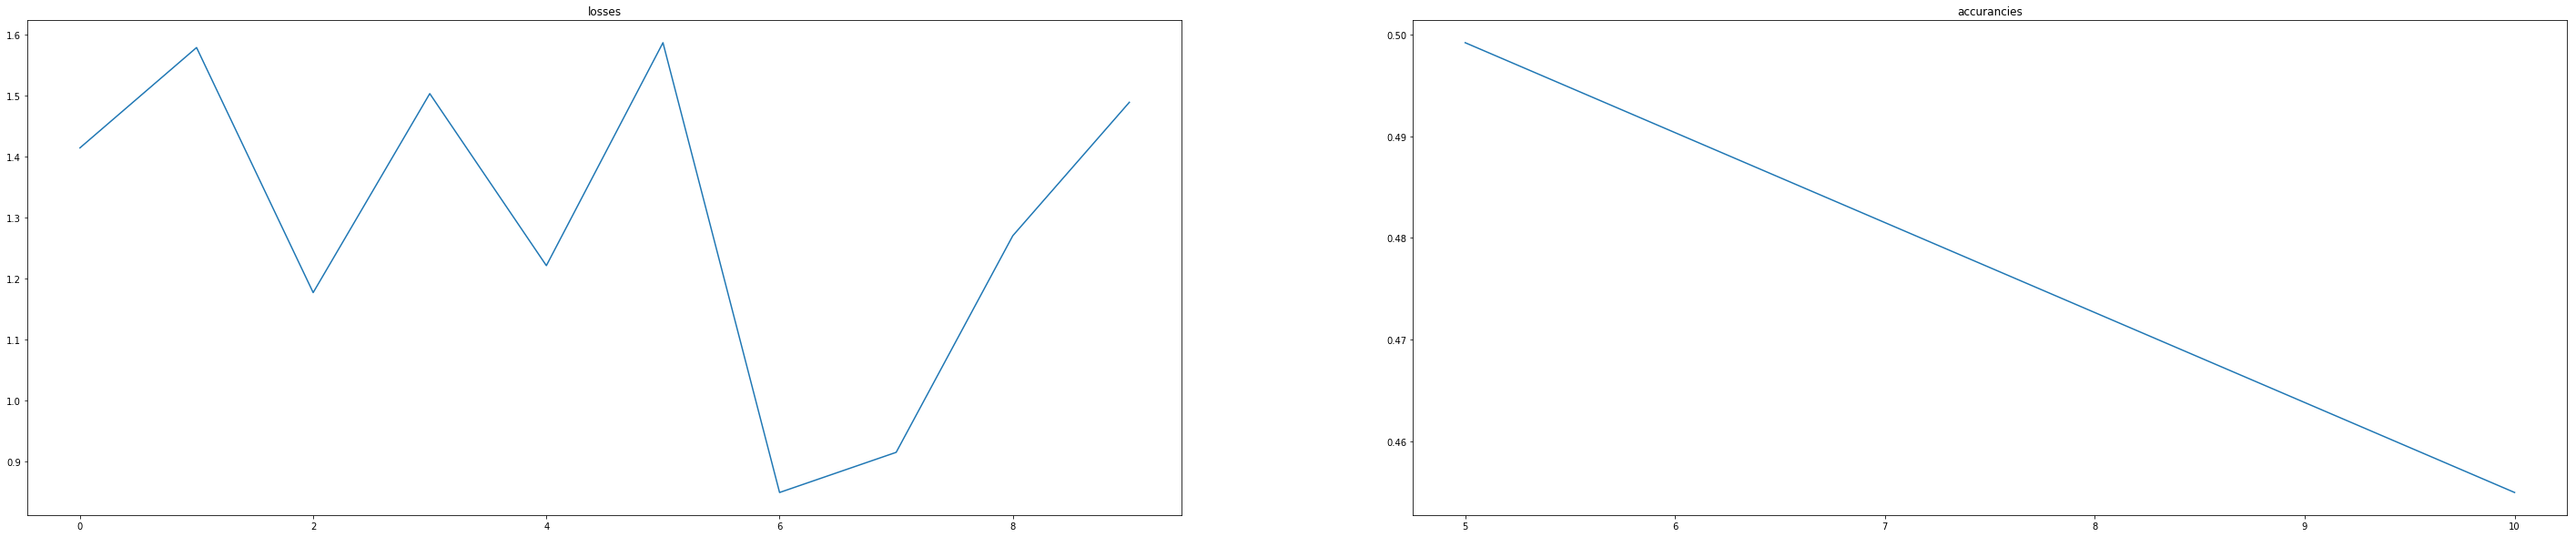

In [187]:
# training parameters
saving_dir = './models/'
if(not os.path.exists(saving_dir)):
    os.mkdir(saving_dir)

model_name = 'model_test'
training_params = {}
training_params['learning_rate'] = 1e-3
training_params['batch_size'] = 32 #512 # number of patches in a mini-batch
training_params['steps_per_epoch'] = 5#int(float(training_dataset.get_lenght())/training_params['batch_size']) # number of iterations per epoch
training_params['epochs'] = 2 # number of epochs

training_params['optimizer'] = SGD(lr=training_params['learning_rate'], momentum=0.9, nesterov=True)
training_params['loss'] = ['categorical_crossentropy']
training_params['metrics'] = ['accuracy']
training_params['training_dataset'] = training_dataset
training_params['validation_dataset'] = validation_dataset

training_params['saving_dir'] = saving_dir
training_params['model_name'] = model_name

training_params['use_sampling_strategy'] = False 
training_params['sampling_threshold'] = 0.75



# train model
train_model(model, training_params)

# Test model

In [ ]:
# load the best model
model = createResNet50(in_t, True)
model_path = os.path.join(saving_dir, model_name+'.h5')
model.load_weights(model_path)

In [ ]:
#get traing data set
x_test = test_dataset.get_data()
print(test_dataset.get_lenght())
print(x_test.shape)

In [25]:
#make predictions
predictions = model.predict(x_test)
print(predictions.shape)

(32768, 2)


In [26]:
#We only need the second column because it holds the prediction of being cancer
pred_cancer = predictions[:,1]
#cases an array holding the index
cases = np.arange(test_dataset.get_lenght())

# Make submission

In [27]:
pd_columns = ['case', 'prediction']
df = pd.DataFrame(columns = pd_columns)
df['case']       = cases
df['prediction']       = pred_cancer

submission_dir = "./submissions/"
if(not os.path.exists(submission_dir)):
    os.mkdir(submission_dir)

df.to_csv(os.path.join(submission_dir,'submit_'+model_name+'.csv'), index=False)  

In [ ]:
#

In [ ]:
#

In [ ]:
#